In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from bosonicplus.interferometers.symplectics import rotation
from bosonicplus.interferometers.ops import apply_symplectic
from bosonicplus.states.from_sf import prepare_cat_bosonic, prepare_gkp_bosonic
from bosonicplus.states.coherent import outer_coherent, eps_fock_coherent, eps_superpos_coherent
from bosonicplus.states.wigner import get_wigner_coherent
from strawberryfields.backends.states import BaseBosonicState
from bosonicplus.plotting import plot_wigner_marginals
import matplotlib.pyplot as plt
from scipy.special import factorial
import strawberryfields as sf
from strawberryfields.backends.bosonicbackend import ops

from bosonicplus.interferometers.parameters import gen_interferometer_params
from bosonicplus.interferometers.construct import build_interferometer
from bosonicplus.measurements.photon_counting import post_select_fock_coherent

from time import time

In [701]:
class PureBosonicState:
    """Store a pure bosonic state as superposition of coherent states by tracking its amplitudes and coherent state amplitudes
    """
    def __init__(self, pure_data : tuple):
        """
        pure_data = [means, covs, coeffs]
        """
        self.pure_data = pure_data
        self.coeffs = pure_data[2]
        self.covs = pure_data[1]
        self.means = pure_data[0]
        self.alphas = pure_data[0]/np.sqrt(sf.hbar*2)
        self.num_alphas = len(self.means)

    def get_dm_form(self):
        means = []
        covs = np.eye(2)
        cs = self.coeffs
        weights = []

        for i in range(self.num_alphas):
            for j in range(self.num_alphas):
                
                mij, cov, cij = outer_coherent(self.alphas[i], self.alphas[j])
                weights.append(cs[i]*np.conjugate(cs[j])*cij)
                #weights[i,j] *= cij
                means.append(mij)
        
        self.data = np.array(means), covs, np.array(weights)/np.sum(weights)
        
    def get_fock_probs(self, cutoff = 10):
        ns = range(cutoff)
        ps = np.zeros(cutoff,dtype='complex')
        cs = self.coeffs
        a = self.alphas
        for n in ns: 
            
            for i in range(self.num_alphas):
                ps[n] += cs[i]* np.exp(-np.abs(a[i])**2/2) * a[i]**n/ np.sqrt(factorial(n))
                
        
        self.fock_probs = np.abs(ps)**2

def coherent_overlap(mu1, mu2):
    """
    mu1 = alpha + 1j beta
    mu2 = delta +1j gamma
    """
    delta_m = mu1 - mu2 
    delta_p = mu1 + mu2
    exparg = - delta_m.imag**2 - delta_m.real**2 + 2*1j*delta_m.imag*delta_p.real
    
    return np.exp(1/4*exparg)

def fock_coherent_pure(N, inf=1e-4, eps = None):
    """Generate the wavefunction data for a Fock state N in the coherent state representation.
    
    Args:
        N (int): fock number
        infid (float): infidelity of approximation
        eps (None or float): coherent state amplitude, takes presidence over infid if specified.
    Returns:
        [mus, covs, coeffs] : tuple, data tuple for the pure state

            In particular, mus = sqrt(2*hbar)*alphas, so real part is disp in x, imag part is disp in p 
        
    See Eq 28 of http://arxiv.org/abs/2305.17099 for expansion into coherent states.
    """
    
    alphas = []
    theta = 2*np.pi/(N+1)

    coeffs = []
    if N == 0:
        alphas.append(0)
        coeffs.append(1)
        
    else:
        
        if not eps:
            eps = eps_fock_coherent(N, inf)
        
        for k in np.arange(N+1):
    
            alpha = eps * np.exp(1j * theta * k) 
            alphas.append(alpha)
            coeffs.append(np.exp(-theta*1j*N*k))

        coeffs = np.array(coeffs)
        factor = np.sqrt(factorial(N))/(N+1) * np.exp(eps**2/2)/eps**N
        norm_est = 1+eps**(2*(N+1))/factorial(N+1)
        #print(norm_est)
        coeffs *= factor
        #coeffs /= np.sqrt(norm_est)
        #coeffs /= np.sqrt(np.sum(np.abs(coeffs)**2))

    #Normalise the coefficients
    
    norm = 0
    for k, ck in enumerate(coeffs):
        norm += np.abs(ck)**2
        l = k+1
        if len(coeffs) - 1 >= l > k: 
            cl = np.conjugate(coeffs[l])
            norm += 2*np.real(ck*cl * coherent_overlap(alphas[k], np.conjugate(alphas[l])))
            l+=1
    #print(norm)
    coeffs/=np.sqrt(norm)

    covs = sf.hbar/2*np.eye(2) #Vacuum state
    
    return np.sqrt(2*sf.hbar)*np.array(alphas), covs, coeffs


def gkp_coherent_pure(n, type, infid=1e-4):
    rho = gkp_nonlinear_squeezing_operator(n, 1, type=type)

    w, v = np.linalg.eigh(rho)
    
    coeffs_n = v[:,0] #eigs always sorted from lowest to highest eigenvalue, choose lowest

    alphas, coeffs = fock_superpos_coherent(coeffs_n, infid)


    return np.sqrt(sf.hbar*2)*alphas, sf.hbar/2*np.eye(2), weights
    
    
def prepare_coherent(alpha):
    weights = np.array([1])
    means = np.array([np.array([alpha.real, alpha.imag])])*np.sqrt(sf.hbar*2)
    covs = np.array([np.eye(2)])
    return BaseBosonicState([means, covs, weights], 1, 1)

In [702]:
fock_coherent_pure(1)

(array([ 0.31301692+0.00000000e+00j, -0.31301692+3.83335164e-17j]),
 array([[1., 0.],
        [0., 1.]]),
 array([ 4.54570513+0.00000000e+00j, -4.54570513-5.56688324e-16j]))

In [703]:
np.sqrt(1.000100010001)

1.0000500037503124

In [704]:
from bosonicplus.measurements.photon_counting import gen_fock_coherent

## Do a photon measurement on a Gaussian pure state

In [705]:
def customsqrt(alpha):
    """Returns the positive sqrt of a complex number

    Args: 
        alpha : complex, r*exp(theta)
    Returns:
        (np.sqrt(r), theta/2) : tuple, 
    """
    r = np.abs(alpha)
    theta = np.angle(alpha)
    #r, theta = polar(alpha)
    if theta < 0: 
        theta += 2*np.pi
    return (np.sqrt(r), theta/2)

#Get the phase matrix from the covariance matrix

def decomp_cov(cov : np.ndarray):
    """Decompose covariance matrix into cov = [[A, C],[C.T, B]]

    Args: 
        cov : ndarray, covariance matrix in xxpp
    Returns:
        A, B, C : tuple
    """
    #Get number of modes
    N = int(cov.shape[-1])
    Nhalf = int(N/2)
    A = cov[:, 0:Nhalf,0:Nhalf]
    B = cov[:, Nhalf::, Nhalf::]
    C = cov[:, 0:Nhalf,Nhalf::] #xp correlations
    return A, B, C

def get_phase_mat(cov : np.ndarray):
    """Get phase matrix from covariance matrix

    Args:
        cov : ndarray, covariance matrix in xxpp

    Returns: 
        Phi : ndarray, phase matrix
    """
    A, B ,C = decomp_cov(cov)
    Ainv = np.linalg.inv(A)
    return Ainv+1j*np.transpose(C,axes=[0,2,1]) @ Ainv

def chop_phase_mat(Phi, idx):
    """Chop phase matrix into A and B modes

    Args:
        Phi (ndarray): phase mat
        idx (int): index of mode B
    Returns:
    (phiA, phiBA, phiB): partitioned phase matrix
    """
    phiA = np.delete(Phi, idx, axis = 1)
    phiA = np.delete(phiA, idx, axis = 2)
    phiB = Phi[:,idx,idx]
    phiBA = np.delete(Phi[:,idx,:],idx,axis=1)
    return (phiA, phiBA, phiB)

def chop_disp_vec(mu, idx):
    """
    Args:
        mu (ndarray): complex array containing x (real) and p (imag) displacements
        idx (int): index of mode B
    Returns:
        (muA, muB) : partitioned displacements
    """
    muA = np.delete(mu,idx,axis=1)
    muB = mu[:,idx]
    return (muA, muB)

def get_phase(Phi, mu, phiM, muM):
    nmodes = int(np.shape(Phi)[1]/2)
    #Chop up Phi
    phiA, phiBA, phiB = chop_phase_mat(Phi,idx)
    muA, muB = chop_disp_vec(mu,idx)
 
    phiB = np.squeeze(phiB) #We always measure one mode at a time, so this also has shape (1,1,1)
    phiMc = np.conjugate(phiM)
    
    phiW = phiB+phiMc
    #print('phiW', phiW, 2*np.cosh(r)**2) #For two mode squeezing example
    
    w = 1/phiW*(phiB*muB.real[np.newaxis,:] + phiMc*muM.real[:,np.newaxis])
    #print('w', w, 1/(np.cosh(r)**2)*muM.real/2, w.shape)
   
    exparg1 = -1/2*((muB.real[np.newaxis,:])**2*phiB + (muM.real[:,np.newaxis])**2*phiMc - w**2*phiW)
    #print('exparg1',exparg1, (muM.real/2)**2 * (1/(np.cosh(r)**2)-2))
    
    
    
    delta_imag = muB.imag[np.newaxis,:] - muM.imag[:,np.newaxis]
    #print('delta_imag**2', delta_imag**2, [i**2 for i in delta_imag])
    exparg2 = 1j*delta_imag*w - delta_imag**2/(2*phiW)
    #print('exparg2', exparg2, (muM.imag/2)**2 * 1/(np.cosh(r))**2 - 1j*2*(muM.real/2)*(muM.imag/2)*1/(np.cosh(r)**2))
    exparg3 = 1j/phiW* delta_imag * np.einsum("...j,...j", phiBA, muA.real)
    

    phi_A_tilde = phiA - (phiBA.T @ phiBA)/phiW 
   
    #print('muB - muM:',delta_imag.shape, phiBA.shape)
    
    s_prime = muA.imag - 1/phiW* delta_imag @ phiBA
    
    delta_re = muB.real[np.newaxis,:] - w
    t_prime = muA.real + np.einsum("...jk,...k", np.linalg.inv(phi_A_tilde) ,delta_re @ phiBA)

    exparg4 = 1/2*delta_re**2 * np.squeeze((phiBA @ np.linalg.inv(phi_A_tilde) @ phiBA.T))

    exparg = exparg1+exparg2+exparg3+exparg4

    phase = exparg.imag    

    delta = muM[np.newaxis,:] - muB[:, np.newaxis]
    

    #print('phase', phase , -2*1j*muM.real/2*muM.imag/2*1/(np.cosh(r))**2)

    #Constants
    N1 = (np.linalg.det(Phi.real)/(np.pi)**nmodes)**(1/4)
    #print('N1', N1.shape)
    N2 = (phiM.real/(np.pi))**(1/4)
    #print('N2',N2.shape)
    
    #Getting the positive sqrt of a complex number correctly
    a, phi = customsqrt(phiW) #Will always just be a number
    

    N3 = np.sqrt(2*np.pi)/(a * np.exp(1j*phi))
    #print(N3)
    N3 = np.sqrt(2*np.pi/phiW)
    #print(N3)
    N3 = np.sqrt(1/phiW)
    norm = N1*N2*N3
    norm = N3
    #norm = 1
    
    #print('N3', N3.shape)
    #N4 = np.exp(-1/2*((muB.real[np.newaxis,:])**2*phiB + (muM.real[:,np.newaxis])**2*np.conjugate(phiM) - w**2*phiW))
    #print('N4', N4.shape)
    
    #If we want to dealing with case where displacements are complex
    comp = False
    if comp: 
        print('Doing complex part:', comp)
    
        alpha = s_prime.real
        beta = s_prime.imag
        delta = t_prime.real
        gamma = t_prime.imag
        
        t_prime = delta - np.einsum("...jk,...k",np.linalg.inv(phi_A_tilde), beta)
        s_prime = alpha + np.einsum("...jk,...k",phi_A_tilde, gamma)
        #print(t_prime.shape)
        
        #print(alpha.shape, beta.shape)
        
        arg1 = 1/2*np.einsum("...j,...jk,...k", gamma, phi_A_tilde, gamma)
        arg2 = -1j*np.einsum("...j,...jk,...k", gamma, phi_A_tilde, delta)
        arg3 = -1/2*np.einsum("...j,...jk,...k",delta, phi_A_tilde, delta)
        dlta = np.einsum("...jk,...k", phi_A_tilde, delta) - beta
        arg4 = 1/2*np.einsum("...j,...jk,...k",dlta,np.linalg.inv(phi_A_tilde), dlta)
        
        #print(arg1.shape, arg2.shape, arg3.shape, arg4.shape)
        exparg_c = np.array([arg1+arg2+arg3+arg4]).T
        print(exparg_c.shape, exparg.shape)
        #print(exparg_c.shape)

        exparg += exparg_c
        
        #M4 = np.array([np.exp(exparg_c)]).T
    #print(exparg1.shape)
    

    

    # Now, get the probability
    
    
    #print('M4', M4.shape)
    
    #norm = 1
    #norm = N1*N2*N4
    
    #normfull = N1*N2*N3*N4*M1*M2*M3*M4
    
    #phase = np.angle(norm)
    #phasefull = np.angle(normfull)
    #phase = np.angle(normfull)
    #print('Phase from imag constants equal to phase from all constants: ', np.allclose(phase, phasefull))

    
    return phi_A_tilde, t_prime, s_prime, norm, exparg, phase
    

def post_select_fock_pure(data, n, mode, inf = 1e-4):

    means, covs, weights = data
    #Obs: what's the convention for the means? Is it size (nmodes) or (2*nmodes), i.e. is the real or complex elements? 
    sigma_xxpp = np.array([xpxp_to_xxpp(i) for i in covs])

    mu = means[:,0::2]+1j*means[:,1::2] #OBS: these are (x, nmodes) shape. The real part is the disp in x and the imaginary part is the disp in p
    #But, is not the alpha, as there is no division by sqrt(2*hbar)

    Phi = get_phase_mat(sigma_xxpp)

    #The fock state PVM in coherent state representation
    means_f, sigma_f, coeffs_f = fock_coherent_pure(n, inf)

    print(np.shape(means_f), np.shape(sigma_f), np.shape(coeffs_f))

    #Get phase matrix of PVM
    phiM = get_phase_mat(np.array([sigma_f])) #Will always be (1,1,1), so can squeeze it
    phiM = np.squeeze(phiM)

    phi_A_tilde, t_prime, s_prime, norm, exparg,phase = get_phase(Phi, mu, phiM, means_f)

    return coeffs_f, phi_A_tilde, t_prime, s_prime, norm, exparg, phase

    
    

    


In [706]:
def prob_tool(coeffs_f, phi, t, s, phase):

    dt  = t[np.newaxis, : ] - np.conjugate(t[:, np.newaxis])
    ds = s[np.newaxis,:] - np.conjugate(s[:,np.newaxis])
    
    
    sigma_ABC = sigma_AB @ C_inv 
    
    sigma_A_tilde = sigma_ABC @ sigma_AB.transpose(0, 2, 1)
    sigma_A_prime = sigma_A - sigma_A_tilde

    delta_B = means_f[np.newaxis,:,:] - r_B[:,np.newaxis,:]

    r_A_tilde = np.einsum("...jk,...k", sigma_ABC, delta_B)
    r_A_prime = r_A[:,np.newaxis,:] + r_A_tilde 
    r_A_prime = r_A_prime.reshape([M*N,L])
    
    reweights_exp_arg = np.einsum("...j,...jk,...k", delta_B, C_inv[np.newaxis,:,:], delta_B)
    #print('Shape reweights_exp_arg' ,reweights_exp_arg.shape)

    Norm = np.exp(-0.5 * reweights_exp_arg) / (np.sqrt(np.linalg.det( 2* np.pi * C))) 

In [707]:
from cmath import polar, sqrt
from thewalrus.symplectic import xpxp_to_xxpp, xxpp_to_xpxp
from thewalrus.symplectic import two_mode_squeezing, squeezing, beam_splitter,expand, xxpp_to_xpxp
from strawberryfields.backends.bosonicbackend.bosoniccircuit import BosonicModes

## Make an two-mode squeezed state

num = 2
r = 1

S = expand(two_mode_squeezing(r,0),[0,1],num)
    
    
sigma_xxpp = np.array([S@np.eye(nmodes*2)@S.T])
#sigma_xxpp = np.array([Stot@np.eye(nmodes*2)@Stot.T])
sigma = np.array([xxpp_to_xpxp(i) for i in sigma_xxpp])

print(sigma.shape)

mu_xxpp = np.array([np.zeros(nmodes)]) #This is the complex dispvector


ns = np.arange(10)
ps = np.zeros(10)
for n in ns:
    #n = 1
    idx = 0
    print(n)

    circuit = BosonicModes(num)
    circuit.means = np.array([np.zeros(2*num)])
    circuit.covs = sigma
    circuit.success = 1
    #circuit = build_interferometer(params, num, out=True)
    data = [circuit.means, circuit.covs, circuit.weights]
    
    inf = 1e-3
    
    ptheory = 1/np.cosh(r)**2 * np.tanh(r)**(2*n)
    print('Theoretical probability: ', ptheory)
    
    #sigma_xxpp = np.array([xpxp_to_xxpp(circuit.covs[0])]).real
    t0 = time()
    post_select_fock_coherent(circuit, idx, n, inf=inf)
    print('Prob from Wigner fock method:', circuit.success)
    t1 = time()
    print('Runtime: ', t1-t0)
    
    ps[n] = circuit.success

(1, 4, 4)
0
Theoretical probability:  0.4199743416140261
Prob from Wigner fock method: (0.419974341614026+0j)
Runtime:  0.0003819465637207031
1
Theoretical probability:  0.24359589399989137
Prob from Wigner fock method: (0.24343434779240125+0j)
Runtime:  0.00039196014404296875
2
Theoretical probability:  0.1412918687974069
Prob from Wigner fock method: (0.14117823770647953+0j)
Runtime:  0.00038886070251464844
3
Theoretical probability:  0.08195290922380058
Prob from Wigner fock method: (0.0818802961933757+9.920280770855644e-18j)
Runtime:  0.0004999637603759766
4
Theoretical probability:  0.04753479012918088
Prob from Wigner fock method: (0.04749041740403118+4.3254886806553327e-19j)
Runtime:  0.0011179447174072266
5
Theoretical probability:  0.02757139794091723
Prob from Wigner fock method: (0.02754490189794795-3.943136753686491e-18j)
Runtime:  0.001033782958984375
6
Theoretical probability:  0.0159921182433022
Prob from Wigner fock method: (0.01597649460800594+0j)
Runtime:  0.001274108

/var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_96008/730515818.py:49: ComplexWarning: Casting complex values to real discards the imaginary part


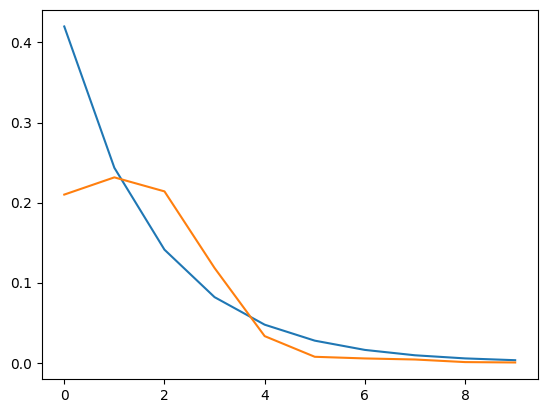

In [713]:
plt.plot(range(10),ps)
plt.plot(range(10),ps_2)

#plt.plot(range(10), ps/ps_2)

In [711]:
ps_2 = np.zeros(10)
for n in ns:
    print('n:', n)
    inf = 1e-4
    
    means_f, sigma_f, coeffs_f = fock_coherent_pure(n, inf = inf)
    
    #print('means_fock:', means_f)
    #print('coeffs_fock:', coeffs_f)
    
    #t0 = time()
    
    coeffs_f, phi_A_tilde, t_prime, s_prime, norm, exparg, phase  = post_select_fock_pure(data, n, idx, inf = inf)
    
    #print('t', t_prime, t_prime.shape)
    #print('s', s_prime, s_prime.shape)
    #print('phase', phase)
    #print('phi', phi_A_tilde,phi_A_tilde.shape)

    p = np.squeeze(get_prob(coeffs_f, phi_A_tilde, t_prime, s_prime, norm, exparg, phase))
    print(p)
    ps_2[n] = p


n: 0
(1,) (2, 2) (1,)
(0.2099871708070128+0j)
n: 1
(2,) (2, 2) (2,)
(0.2314975540746182+0j)
n: 2
(3,) (2, 2) (3,)
(0.21399727519378325+0j)
n: 3
(4,) (2, 2) (4,)
(0.11828205661608863+1.457078699411507e-18j)
n: 4
(5,) (2, 2) (5,)
(0.033192919288505006+0j)
n: 5
(6,) (2, 2) (6,)
(0.00738400955567784-1.8213483742643837e-19j)
n: 6
(7,) (2, 2) (7,)
(0.005324482599309712+9.106741871321919e-20j)
n: 7
(8,) (2, 2) (8,)
(0.004005966230899022+0j)
n: 8
(9,) (2, 2) (9,)
(0.0007659117485265718-7.11464208697025e-21j)
n: 9
(10,) (2, 2) (10,)
(0.0002819724185747267+7.114642086970249e-22j)


/var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_96008/1091882890.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


0.36

In [583]:
def get_prob(coeff, phi, t, s, norm, exparg,phase):

    #print(phi_A_tilde.shape)
    #print(t_prime.shape)
    #print(s_prime.shape)
    #print(exparg.shape)
    #print(exparg.shape)
    
    nmodes = int(phi.shape[2])
    #print(nmodes)
    #expargk = -1/2*np.einsum("...j,...jk,...k",t_prime, phi_A_tilde, t_prime)
    #expargl = -1/2*np.einsum("...j,...jk,...k",np.conjugate(t_prime), np.conjugate(phi_A_tilde), np.conjugate(t_prime))

    phi_c = np.conjugate(phi)
    phi_rinv = np.linalg.inv(phi.real)
    tc = np.conjugate(t)
    sc = np.conjugate(s)
    prob = 0

    #Start with diag term
    
    #ck = np.abs(coeff)[np.newaxis,:]
    #ark = np.abs(np.exp(exparg))

    
    #sk = s - sc
    
    #tk = 1/2*(t @ phi + tc @ phi_c) @ phi_rinv
    #skk = s_prime - np.conjugate(s_prime)
    #sk = 2*1j*s.imag


    #print(norm.shape)
    #print(tkk1,tkk)
    #K_exparg1 = -1/2 * t_prime **2 @ phi_A_tilde - 1/2*np.conjugate(t_prime)**2 @ np.conjugate(phi_A_tilde)
    
    #K_exparg = - (t**2 @ phi ).real + 0j


    #K_exparg += 1/2*tk**2 @ phi.real

    #C_exparg = 1j*sk*tk - 1/2* sk**2 @ phi_rinv
    

    #expargskk = arg1 + K_exparg + C_exparg
    #Dkk =  ck @ ark * np.abs(np.exp(K_exparg+C_exparg))
    #print(Dkk.shape)
    #prob += np.sum(Dkk)
    #imax = len(ck)-1
    #print(t)
    #print(s)
    for i, ti in enumerate(t):
        #j = i+1
        si = s[i]
        ci = coeff[i]
        for j, tj in enumerate(tc):
            
        #while j <= imax: 
            #if j > i:
            sj = sc[j]
            tij = 0.5*(ti * phi + tj * phi_c ) * phi_rinv
            #print(tij.shape)
            sij = si - sj
            cj = np.conjugate(coeff[j])
            
            K_expargij = -1/2 * ti **2 * phi - 1/2*tj**2 * phi_c 
            
            K_expargij += 1/2*tij**2 * phi.real
            #K_expargij += tij**2 * phi.real
    
            #C_expargij = 1j*sij * tij -0.5*sij**2 * phi_rinv
            C_expargij = 1j*sij * tij -0.5*sij**2 * phi_rinv
           
            arij = exparg[i] + np.conjugate(exparg[j])
           
            
            #prob += 2*(ci *cj*np.exp(arij + K_expargij + C_expargij)).real 
            prob += ci*cj*np.exp(arij + K_expargij + C_expargij)
            #print('prob:', np.exp(arij + K_expargij + C_expargij))
            #j+=1 
    #print(prob.shape)
    #prob *= norm * np.conjugate(norm)* np.sqrt(np.pi**nmodes/(np.linalg.det(phi.real)))

    prob *= norm * np.conjugate(norm)
    #prob *= norm **2 * np.sqrt(np.pi**nmodes/(np.linalg.det(phi.real)))

    
    return prob 
           
        
        
    


    

In [45]:
t0 = time()

coeffs_f, phi_A_tilde, t_prime, s_prime, norm , exparg = post_select_fock_pure(data, n, idx)

print('t', t_prime, t_prime.shape)
print('s', s_prime, s_prime.shape)
print('norm', norm, norm.shape)
print('phi', phi_A_tilde)
print('exparg', exparg, exparg.shape)

print('norm*exparg', norm * np.exp(exparg))

p = get_prob(coeffs_f, phi_A_tilde, t_prime, s_prime, norm, exparg)
#print(np.sqrt(p))
tf = time()
print(tf-t0)

(3,) (2, 2) (3,)
Phi shape: (1, 1, 1) (1, 1) (1,)
mu shape: (1, 1) (1,)
phiW (4.762195691083637+0j) 4.762195691083631
muB - muM: (3, 1) (1, 1)
phase:  [[ 0.        ]
 [ 0.06609021]
 [-0.06609021]]
e1 [[-0.28710972+0.j]
 [-0.07177743+0.j]
 [-0.07177743+0.j]]
e2 [[ 0.       +0.j        ]
 [-0.0572358+0.06609021j]
 [-0.0572358-0.06609021j]]
e3 [[0.+0.j]
 [0.-0.j]
 [0.+0.j]]
e4 [[0.21079531+0.j]
 [0.05269883+0.j]
 [0.05269883+0.j]]
n1 [0.75112554]
n2 0.7511255444649425
n3 (1.1486462929513301+0j)
t [[ 0.64930011+0.j]
 [-0.32465005+0.j]
 [-0.32465005+0.j]] (3, 1)
s [[ 0.        +0.j]
 [-0.56231039+0.j]
 [ 0.56231039+0.j]] (3, 1)
norm [0.64805427+0.j] (1,)
phi [[[1.+0.j]]]
exparg [[-0.0763144+0.j        ]
 [-0.0763144+0.06609021j]
 [-0.0763144-0.06609021j]] (3, 1)
norm*exparg [[0.60043839+0.j        ]
 [0.59912754+0.03965422j]
 [0.59912754-0.03965422j]]
(3, 1)
1
[[ 0.64930011+0.j]
 [-0.32465005+0.j]
 [-0.32465005+0.j]]
[[ 0.        +0.j]
 [-0.56231039+0.j]
 [ 0.56231039+0.j]]
(1, 1, 1)
prob: 

In [360]:
#data = [circuit.means, circuit.covs, circuit.weights]
t0 =  time()
coeffs_f, phi_A_tilde, t_prime, s_prime, norm, exparg = post_select_fock_pure(data, n, idx)
t1 = time()
print(t1-t0)

(4,) (2, 2) (4,)
Phi shape: (1, 2, 2) (1, 2) (1,)
mu shape: (1, 2) (1,)
muB - muM: (4, 1) (1, 2)
0.0013282299041748047


0.806225774829855

In [65]:
print(t_prime.shape)

means_new_xxpp = np.concatenate((t_prime, s_prime), axis = 1) 
means_new = 
print(means_new.shape)
munew = t_prime + 1j*s_prime
print(munew.shape)

(21, 4)
(21, 8)
(21, 4)


In [57]:
new_data = [circuit.means, circuit.covs, circuit.weights]
phase, phi_A_tilde, t_prime, s_prime = post_select_fock_pure(new_data, n, idx)

(21,) (2, 2) (21,)
Phi shape: (1, 3, 3) (1, 3) (1,)
mu shape: (441, 3) (441,)
muB - muM: (21, 441) (1, 3)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 441)

In [51]:
21*21

441

In [14]:
sigma_circuit = np.array([xpxp_to_xxpp(circuit.covs[0])])
phi_tilde = get_phase_mat(sigma_circuit)

#Is the resulting covariance matrix equal to the one obtained with the Wigner function method?
print('Phase mat equivalent to the one from the Wigner methods:', np.allclose(phi_tilde, phi_A_tilde))

Phase mat equivalent to the one from the Wigner methods: True


In [ ]:
#Importance of defning a custom sqrt function of a complex number (thanks Niklas). 

theta = np.linspace(0,2*np.pi,100)
plt.title(r'$\tilde{x}=e^{i\tilde{\theta}}=\sqrt{x}$ for $x=e^{i\theta}$')
plt.plot(theta, [polar(sqrt(i))[1] for i in np.exp(1j*theta)], label ='cmath sqrt')
plt.plot(theta, [customsqrt(i)[1] for i in np.exp(1j*theta)], label = 'custom sqrt')
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\tilde{\theta}$')
plt.show()

In [ ]:
means_f, sigma_f, coeffs_f = fock_coherent_pure(6,1e-4)

print(np.shape(means_f), np.shape(sigma_f), np.shape(coeffs_f))

In [ ]:

S = two_mode_squeezing(2,0)

S1 = expand(squeezing(2,0), 0, 2)
S2 = expand(squeezing(2,np.pi),1,2)
BS = beam_splitter(np.cos(np.sqrt(0.5)), 0)
Stot = BS@S2@S1

print(xxpp_to_xpxp(S@np.eye(4)@S.T))
print(xxpp_to_xpxp(Stot@np.eye(4)@Stot.T))
print(np.cosh(2))
print(np.sinh(2))
print(-2*np.cosh(1)*np.sinh(1))




In [ ]:
def project_fock_coherent_pure(n, data, mode, inf=1e-4):  
    """Returns data tuple after projecting mode on fock state n (in coherent approx)
    
    Args:
        n (int): photon number
        data (tuple) : [means, covs, coeffs] OBS: coeffs are the wavefunction coefficients
        mode (int): mode index that is measured with PNRD
        inf (float): infidelity of the fock approx
        
    Returns:
        data_A (tuple): 
        prob (float): probability of the measurement
    """
    means, covs, coeffs = data

    #Given infidelity, find a suitable alpha for fock_coherent
    #alpha = eps_fock_coherent(n, inf)
    
    means_f, sigma_f, coeffs_f = fock_coherent_pure(n, inf)

    phases = np.array([1j*i[0]*i[1] for i in means_f])

    print(means_f.shape, sigma_f.shape, coeffs_f.shape)
    
    modes = [mode]

    mode_ind = np.concatenate((2 * np.array(modes), 2 * np.array(modes) + 1))
    
    sigma_A, sigma_AB, sigma_B = ops.chop_in_blocks_multi(covs, mode_ind)
    r_A, r_B = ops.chop_in_blocks_vector_multi(means, mode_ind)
    
    #New array sizes
    M = len(means_f)
    N = len(r_A)
    L = len(r_A[0,:])
    
    C = sigma_B + sigma_f
    C_inv = np.linalg.inv(C)

    sigma_ABC = sigma_AB @ C_inv 
    
    sigma_A_tilde = sigma_ABC @ sigma_AB.transpose(0, 2, 1)
    sigma_A_prime = sigma_A - sigma_A_tilde

    delta_B = means_f[np.newaxis,:,:] - r_B[:,np.newaxis,:]

    r_A_tilde = np.einsum("...jk,...k", sigma_ABC, delta_B)
    r_A_prime = r_A[:,np.newaxis,:] + r_A_tilde 
    r_A_prime = r_A_prime.reshape([M*N,L])

    reweights_exp_arg = np.einsum("...j,...jk,...k", delta_B, C_inv[np.newaxis,:,:], delta_B)
    #print('Shape reweights_exp_arg' ,reweights_exp_arg.shape)

    Norm = np.exp(-0.5 * reweights_exp_arg) / np.linalg.det(2*np.pi*C)**(1/2) 
    reweights = np.conjugate(coeffs_f[np.newaxis,:]*np.exp(phases[np.newaxis,:]))*coeffs[:,np.newaxis] * np.sqrt(Norm) /(2*np.pi*sf.hbar)**(1/4)
    #Norm  = np.sqrt(np.linalg.det( 2* np.pi * C.reshape([M*N,2,2] )))
    reweights = reweights.reshape([M*N])
    prob = np.sum(np.conjugate(reweights[np.newaxis,:])*reweights[:,np.newaxis])
    #prob = np.sum(np.abs(reweights)**2)
    reweights /=  np.sqrt(prob)
    print(np.sum(np.abs(reweights**2)))

    data_A = r_A_prime, sigma_A_prime, reweights

   
    return data_A, prob

In [ ]:
means_f, sigma_f, coeffs_f = fock_coherent_pure(6,1e-4)

[1j*i[0]*i[1] for i in means_f]



In [ ]:
### Make a simple circuit - Fock state preparation circuit
sf.hbar = 2
num = 2

ti = time()
params = gen_interferometer_params(num,-8)
print(params)

sqz = [[1,0,0],[1,np.pi,1]]
bs = [[np.cos(np.sqrt(0.5)), 0, [0,1]]]
params['sqz'] =sqz
params['bs'] = bs


print('Building the interferometer')
print('-'*50)
circuit = build_interferometer(params, num, out=True)
t1 = time()
print(f'Circuit building time = {t1-ti} s')
n = 5
ns = np.repeat(n, num-1) #Photon pattern

print('\nPerforming photon measurements')
print('-'*50)

T0 = time()

for i, n in enumerate(ns):
    
    t0 = time()
    modes = circuit.get_modes()
    post_select_fock_coherent(circuit, modes[-1], n,out=True)
    t1 = time()
    print(f'Post selection time {t1-t0} s')

T1 = time()

print(f'Total time for measurements {T1-T0} s')

print(f'\nTotal simulation time {T1-ti} s')
print('Probability: ', circuit.success)
x = np.linspace(-10,10,200)
state = BaseBosonicState([circuit.means,circuit.covs,circuit.weights], 1, len(circuit.weights))
W = get_wigner_coherent(state, x,x)
plot_wigner_marginals(W,x,x,'')
plt.show()

In [ ]:
from bosonicplus.interferometers.symplectics import beamsplitter, squeeze

In [ ]:
#Create vacuum state
means = np.zeros(4)
covs = np.eye(4)

S1 = squeeze(1, 0, 0, 2)
S2 = squeeze(1,np.pi,1,2)
S3 = beamsplitter(np.cos(np.sqrt(0.5)),0,0,1,2)

Stot = S3@S2@S1

data = apply_symplectic([np.array([means]), np.array([covs]), np.array([1])], Stot)

state = PureBosonicState(data)

new_data, prob = project_fock_coherent_pure(5, data, 1)

print(prob)

In [ ]:
(2*np.pi*2)

In [ ]:
0.02309/0.01599

In [ ]:
np.sqrt(2)

In [ ]:
print(np.conjugate(new_data[2][np.newaxis,:]*new_data[2][:,np.newaxis]))

In [ ]:
print(circuit.weights)

In [ ]:
5.60934115/5.60201609

In [ ]:
0.023/0.015992668838124557

In [ ]:
5.60934115/6.72241931